![image](https://user-images.githubusercontent.com/85720162/182034807-7f59fb8c-3c15-4c6b-a008-c6675526dba6.png)

**BUSINESS PROBLEM**

A Webmotors dispõe de diversos produtos digitais para solucionar problemas durante a compra, utilização e venda de um veículo, sendo um de seus principais e mais conhecidos o classificado. Para o classificado utilizamos o lead model para monetizar nosso produto. Um lead é uma demonstração de interesse de um comprador para um vendedor. Navegue no nosso portal, pesquise um veículo e abra a página de um anúncio para se familiarizar com os conceitos.
Nesta planilha (autoexplicativa, veja a aba de dicionário para entender) você encontra alguns números fictícios dos nossos clientes.

**Desafio**

A fim de melhorar o desempenho dos anúncios, determine ao menos uma alternativa para potencializar o recebimento de leads dos anúncios. Para tal, elaboramos um roteiro em duas partes para te guiar neste desafio:

**Parte 1:** Faça uma exploração dos dados e mostre como a quantidade de leads varia de acordo com as outras variáveis (por exemplo, a marca ou o modelo afetam o recebimento de leads? O comportamento observado é o mesmo em todas as cidades?).

**Parte 2:** Proponha um modelo para determinar se um anúncio receberá lead. Que outras informações, as quais você não teve acesso, poderiam ajudar a chegar a conclusões melhores?

**Desafio Bônus:** Proponha um modelo para determinar a quantidade de leads que um anúncio irá receber










**O projeto foi realizado de forma cíclica (metodologia CRISP-DM), sendo cada iteração uma melhoria do que foi desenvolvido anteriormente.**

**Esse notebook representa o primeiro ciclo da solução.**

# 1. IMPORTS

In [33]:
import pickle
import sys

import pandas            as pd
import numpy             as np
import seaborn           as sns
import matplotlib.pyplot as plt

import lightgbm

from sklearn.metrics         import mean_squared_error, ConfusionMatrixDisplay, confusion_matrix, precision_score, recall_score, accuracy_score, f1_score, roc_auc_score, classification_report, roc_curve
from sklearn.model_selection import RepeatedKFold, cross_val_score, StratifiedKFold, train_test_split
from sklearn.preprocessing   import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.ensemble        import RandomForestClassifier
from sklearn.naive_bayes     import GaussianNB

from imblearn import combine as c
from skopt    import BayesSearchCV

## 1.1. Helper Functions & Configurations

In [34]:
# utilizado na seção Data Description & Cleaning -> Check Data Types
def bin_change(feature):
    
    # mapeia dados categóricos(S/N) em 0 e 1
    feature = feature.map({'S':1, 'N':0})
    
    return feature

In [35]:
# utilizado na seção Machine learning -> CV Comparison
def get_size(model):
    
    # salva em pickle
    obj = pickle.dumps(model)
    
    # obtem o tamanho em bytes
    bytes_size = sys.getsizeof(obj)
    
    # converte para megabytes
    model_size = bytes_size / (1024*1024)
    
    return model_size

In [36]:
# Utilizado na seção Machine Learning
def compute_metrics(y_true, y_pred, model_name):
        
        # calcular métrica
        prc_score = f"{precision_score(y_true, y_pred):.3f}"
        rcl_score = f"{recall_score(y_true, y_pred):.3f}"
        f1s_score = f"{f1_score(y_true, y_pred):.3f}"
        roc_score = f"{roc_auc_score(y_true, y_pred):.3f}"
        acc_score = f"{accuracy_score(y_true, y_pred):.3f}"
        
        # exibir em um Data Frame
        df_metrics = pd.DataFrame({'Model': model_name,
                                   'Precision (Avg+Std)': prc_score,
                                   'Recall (Avg+Std)': rcl_score,
                                   'F1-Score (Avg+Std)': f1s_score,
                                   'ROC-AUC (Avg+Std)': roc_score,
                                   'Accuracy (Avg+Std)': acc_score}, index=[0])
        
        return df_metrics

In [37]:
# Utilizado na seção Machine Learning -> Cross-Validation
def cross_validation(model, model_name, X, y, cv):
        
        # realizar cv e calcular métrica
        prc_cv = cross_val_score(model, X, y, cv=cv, scoring='precision', n_jobs=-1)
        rcl_cv = cross_val_score(model, X, y, cv=cv, scoring='recall', n_jobs=-1)
        f1s_cv = cross_val_score(model, X, y, cv=cv, scoring='f1', n_jobs=-1)
        roc_cv = cross_val_score(model, X, y, cv=cv, scoring='roc_auc', n_jobs=-1)
        acc_cv = cross_val_score(model, X, y, cv=cv, scoring='accuracy', n_jobs=-1)
        
        # formatar
        prc = f"{prc_cv.mean():.3f} +/- %{prc_cv.std():.3f}"      
        rcl = f"{rcl_cv.mean():.3f} +/- %{rcl_cv.std():.3f}"
        f1s = f"{f1s_cv.mean():.3f} +/- %{f1s_cv.std():.3f}"
        roc = f"{roc_cv.mean():.3f} +/- %{roc_cv.std():.3f}"
        acc = f"{acc_cv.mean():.3f} +/- %{acc_cv.std():.3f}"
        
        # exibir em um Data Frame
        df_cv = pd.DataFrame({'Model': model_name,
                              'Precision (Avg+Std)': prc,
                              'Recall (Avg+Std)': rcl,
                              'F1-Score (Avg+Std)': f1s,
                              'ROC-AUC (Avg+Std)': roc,
                              'Accuracy (Avg+Std)': acc}, index=[0])
        
        return df_cv

In [38]:
# Utilizado na seção Hyperparameter Fine Tuning & Evaluate
def plot_cm(y_true, y_pred, model):
    
    # cria a matrix de confusão
    cm = confusion_matrix(y_true, 
                          y_pred, 
                          labels=model.classes_)
    
    # formata e exibe
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                                  display_labels=model.classes_)
    disp.plot()
    
    return plt.show()

In [39]:
# formatar 2 casas decimais
pd.options.display.float_format = '{:.2f}'.format

## 1.2. Load Data

In [40]:
df_raw = pd.read_csv('Case 1 - dados.csv')
df_raw.head()

,cod_anuncio,cod_cliente,cod_tipo_pessoa,prioridade,leads,views,cliques_telefone*,cod_marca_veiculo,cod_modelo_veiculo,cod_versao_veiculo,...,arquente,bancocouro,arcondic,abs,desembtras,travaeletr,vidroseletr,rodasliga,sensorchuva,sensorestacion
0,2,7941,2,3,1,0,0,34,769,346932,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,6,1770,1,3,1,0,4,2,704,340148,...,S,N,N,S,N,S,S,N,N,N
2,8,709,1,3,4,0,11,30,1071,310713,...,S,N,S,S,S,S,S,S,N,N
3,13,9708,1,2,12,0,14,10,2028,341195,...,S,S,S,N,N,S,S,S,N,N
4,15,1363,1,2,8,0,11,12,805,332063,...,S,S,S,S,S,S,S,S,N,N


# 2. DATA DESCRIPTION & CLEANING

In [41]:
df1 = df_raw.copy()

## 2.1. Train & Test Split

O conjunto de dados será dividido em treino e teste, porém, vai ser utilizado o conjunto completo até a etapa da EDA. A partir da etapa do pré-processamento, o conjunto de treino será utilizado (formatado com as alterações realizadas nas etapas anteriores).

In [42]:
# Treino & Teste
df_train, df_test = train_test_split(df1, test_size=0.2, random_state=42)

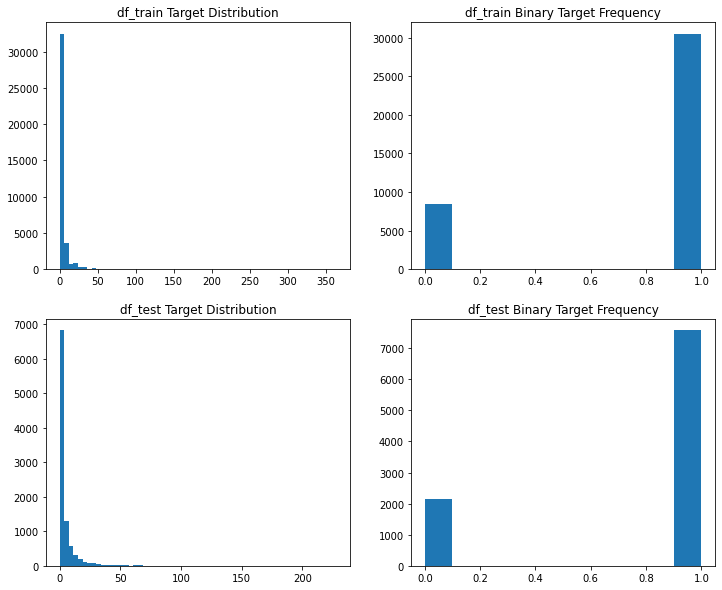

In [43]:
# definir tamanho dos plots
plt.gcf().set_size_inches(12,10)

# visualizar distribuição e frequência (transformação para binário)
plt.subplot(2,2,1)
plt.hist(df_train.leads, bins=60);
plt.title('df_train Target Distribution')

plt.subplot(2,2,2)
plt.hist(np.where(df_train['leads'] > 0, 1, 0));
plt.title('df_train Binary Target Frequency')

plt.subplot(2,2,3)
plt.hist(df_test.leads, bins=60);
plt.title('df_test Target Distribution')

plt.subplot(2,2,4)
plt.hist(np.where(df_test['leads'] > 0, 1, 0));
plt.title('df_test Binary Target Frequency');

## 2.2. Features Description

In [44]:
f_description = pd.read_csv('Case 1 - dicionario.csv')
f_description

,attribute,description
0,cod_anuncio,código do anúncio
1,cod_cliente,código do anunciante
2,cod_tipo_pessoa,"tipo de anunciante: PF=1, PJ=2"
3,prioridade,"prioridade do anúncio (1=alta, 2-média, 3-baixa)"
4,leads,tota de propostas recebidas
5,views,quantidade de visualizações no anúncio
6,cliques_telefone,quantidade de cliques no telefone anunciado
7,cod_marca_veiculo,código da marca do veículo
8,cod_modelo_veiculo,código do modelo veículo
9,cod_versao_veiculo,código da versão do veículo


## 2.3. Ckeck Data Dimensions

In [45]:
print('Quantidade de linhas:', df1.shape[0])
print('Quantidade de colunas:', df1.shape[1])

Quantidade de linhas: 48665
Quantidade de colunas: 41


## 2.4. Check Duplicated Data

In [46]:
df1.duplicated().sum()

0

## 2.5. Check NA Values

In [47]:
df1.isna().sum()

cod_anuncio                             0
cod_cliente                             0
cod_tipo_pessoa                         0
prioridade                              0
leads                                   0
views                                   0
cliques_telefone*                       0
cod_marca_veiculo                       0
cod_modelo_veiculo                      0
cod_versao_veiculo                      0
ano_modelo                              0
cep_2dig                                0
uf_cidade                               0
vlr_anuncio                             0
qtd_fotos                               0
km_veiculo                              0
vlr_mercado                          6217
flg_unico_dono                          0
flg_licenciado                          0
flg_ipva_pago                         312
flg_todas_revisoes_concessionaria     312
flg_todas_revisoes_agenda_veiculo       0
flg_garantia_fabrica                  312
flg_blindado                      

**Os missging values serão excluídos no primeiro ciclo, sendo tratados individualmente nos próximos ciclos.**

In [48]:
# df para análise exploratória
df1.dropna(inplace=True)

# df para modelagem
df_train.dropna(inplace=True)

## 2.6. Check Data Types

In [49]:
# # df para análise exploratória
# Alterar de float para int:
df1['flg_ipva_pago'] = df1['flg_ipva_pago'].astype('int64')                 
df1['flg_todas_revisoes_concessionaria'] = df1['flg_todas_revisoes_concessionaria'].astype('int64')
df1['flg_garantia_fabrica'] = df1['flg_garantia_fabrica'].astype('int64')
df1['flg_adaptado_pcd'] = df1['flg_adaptado_pcd'].astype('int64')

# # df para análise exploratória
# Alterar de float para int:
df_train['flg_ipva_pago'] = df_train['flg_ipva_pago'].astype('int64')                 
df_train['flg_todas_revisoes_concessionaria'] = df_train['flg_todas_revisoes_concessionaria'].astype('int64')
df_train['flg_garantia_fabrica'] = df_train['flg_garantia_fabrica'].astype('int64')
df_train['flg_adaptado_pcd'] = df_train['flg_adaptado_pcd'].astype('int64')

## 2.7. Descriptive Statistics

In [50]:
# numérico
num_attributes = df1[['leads', 'views', 'cliques_telefone*', 'ano_modelo', 'cep_2dig', 'vlr_anuncio', 'qtd_fotos',
                      'km_veiculo', 'vlr_mercado', 'portas']]

# categórico
aux = df1.drop(columns=num_attributes.columns)
cat_attributes = aux.drop(columns='cod_anuncio')

### 2.7.1. Numerical Features

In [51]:
# métricas de tendência central
mean_     = pd.DataFrame(num_attributes.mean()).T
median_   = pd.DataFrame(num_attributes.median()).T

# métricas de dispersão
min_      = pd.DataFrame(num_attributes.min()).T
max_      = pd.DataFrame(num_attributes.max()).T
range_    = pd.DataFrame(num_attributes.max() - num_attributes.min()).T
std_      = pd.DataFrame(num_attributes.std()).T
skew_     = pd.DataFrame(num_attributes.skew()).T
kurtosis_ = pd.DataFrame(num_attributes.kurtosis()).T


metrics = pd.concat([min_, max_, range_, mean_, median_, std_, skew_, kurtosis_]).T.reset_index()
metrics.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
metrics

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,leads,0.00,364.00,364.00,4.20,1.00,11.58,10.17,183.94
1,views,0.00,4872.00,4872.00,410.62,204.00,601.17,3.32,13.87
2,cliques_telefone*,0.00,457.00,457.00,7.06,4.00,10.98,8.65,167.45
3,ano_modelo,1951.00,2019.00,68.00,2013.50,2014.00,3.48,-2.13,15.69
4,cep_2dig,1.00,99.00,98.00,38.40,22.00,33.59,0.50,-1.45
5,vlr_anuncio,4900.00,122000000.00,121995100.00,85192.09,39990.00,1555364.47,55.29,3372.11
6,qtd_fotos,0.00,20.00,20.00,6.68,8.00,2.13,-1.76,2.74
7,km_veiculo,0.00,2147483647.00,2147483647.00,284457.47,59454.00,18194404.20,98.13,10406.11
8,vlr_mercado,6292.84,1111215.64,1104922.80,52746.13,40653.47,41631.47,4.90,48.65
9,portas,0.00,4.00,4.00,3.78,4.00,0.74,-3.59,12.92


*Para o próximo ciclo, verificar o modelo dos veículos com 0 portas (analisar a possibilidade de mapear a quantidade de portas)

- **Excluir veiculos de 0 portas**
- **Excluir anúncios com 0 views**

### 2.7.2. Categorical Features

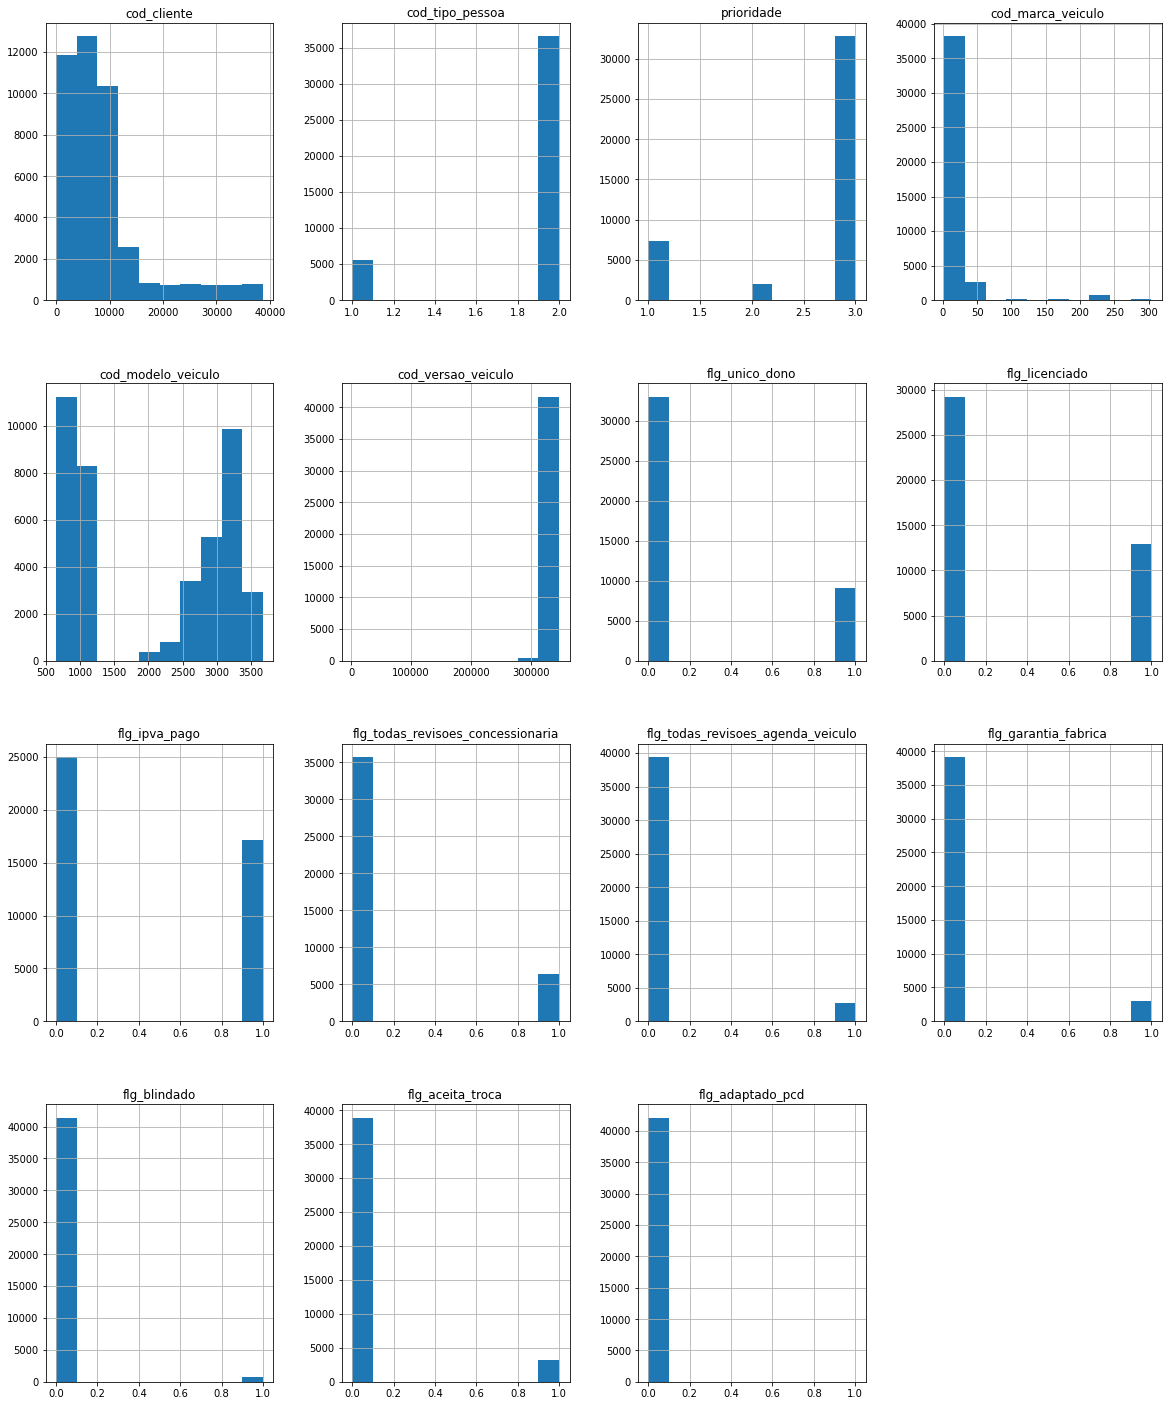

In [52]:
# Frequência
cat_attributes.hist();
plt.gcf().set_size_inches(20,25)

# 3. FEATURE ENGINEERING

In [53]:
df2 = df1.copy()

## 3.1. MindMap

**O MindMap é utilizado para relacionar as características de um determinado fenômeno e suas derivações.**

Objetivo: 

    - Identificar features interessantes para serem analisadas (tanto para exploração como modelagem).
    - Criar hipóteses de négocio que possam vir a gerar insights acionáveis.
    - Conduzir a análise exploratória dos dados.
    - Facilitar o cruzumento de informações para realizar o feature engineering.

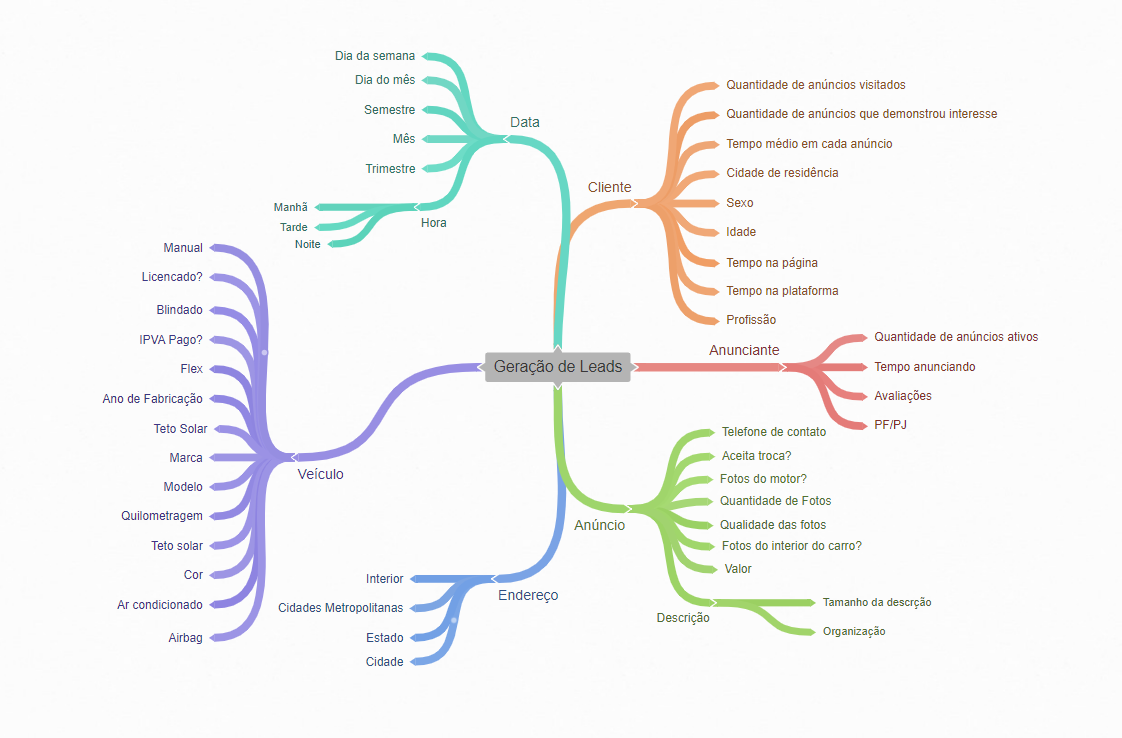

## 3.2. Hyphotesis Creation

### 3.2.1. Veículo

01. Veículos com IPVA pago correspondem a 70% dos anúncios com leads.
03. Duas marcas de veículos correspondem a 60% dos anúncios com leads.
04. Veículos com ano de fabricação inferior a 2010 geram até 20% dos leads.
05. Veiculos brancos e pretos representam no mínimo 70% dos leads.
06. Veiculos Flex correspondem a no mínimo 60% dos leads.

### 3.2.2. Endereço

06. São Paulo concentra 80% dos anúncios que possuem mais de 30 leads.
08. Cidade do interior possuem no máximo 4 leads por anúncio.

### 3.2.3. Anúncio

08. A cada 10 fotos do veículo o anúncio aumenta 20% as chances de receber um lead.
10. Anúncios com fotos de baixa qualidade representam no mínimo 70% dos que não recebem leads.
11. A mediana da quantidade de fotos no anúncio é 2x maior para anúncios que receberam leads.
11. Anúncios com menos de 5 fotos correspondem a no mínimo 70% dos que não recebem leads.
13. Anúncios com fotos do interior do veículo aumentam em 50% as chances de receber um lead.
14. Anúncios com valor do veículo inferior a 10% da tabela FIPE correspondem a 50% dos que recebem leads.
15. Anúncios com descrição menor que 100 palavras correspondem a até 10% dos que recebem leads.
16. Anúncios com mais de 1 mês correspondem a menos que 15% dos que recebem leads.

### 3.2.4. Anunciante

16. Anúncios em que o o anunciante é PJ correspondem a 60% dos que recebem leads.
18. Anúncios em que o o anunciante é PJ correspondem a 80% dos que recebem mais de 5 leads.
19. Anunciantes com avaliação média superior a 4 estrelas tem 50%+ de chances de receber leads.

### 3.2.5. Cliente

19. Clientes homens correspondem a 80%+ de todos os leads da plataforma.
21. 70% dos leads ficam mais de 10 minutos na página do anúncio.
22. Clientes com idade entre 25 e 45 anos correspondem a no mínimo 80% dos leads.
23. 70% dos clientes que viraram leads visitaram no mínimo 5 outros anúncios.

### 3.2.6. Data

23. Sábado e Domingo representam 70%+ dos leads gerados.
25. A primeira quinzena do mês correspondem a 70%+ dos leads gerados.
26. Os meses de Janeiro e Fevereiro representam menos de 15% dos leads gerados.
27. O periodo da noite (18h) concentra 80% dos leads gerados.

### 3.2.7. Hipóteses sem Features para Validar

- **(cor)** - Veiculos brancos e pretos representam no mínimo 70% dos leads.
- **(região metropolitana/rural)** - Cidade do interior possuem no máximo 4 leads por anúncio.
- **(qualidade das fotos)** - Anúncios com fotos de baixa qualidade representam no mínimo 70% dos que não recebem leads.
- **(local das fotos**) - Anúncios com fotos do interior do veículo aumentam em 50% as chances de receber um lead.
- **(quantidade de palavras)** - Anúncios com descrição menor que 100 palavras correspondem a até 10% dos que recebem leads.
- **(avaliação do anunciante)** - Anunciantes com avaliação média superior a 4 estrelas tem 50%+ de chances de receber leads.
- **(gênero do cliente)** - Clientes homens correspondem a 80%+ de todos os leads da plataforma.
- **(tempo médio na página do anúncio)** - 70% dos leads ficam mais de 10 minutos na página do anúncio.
- **(idade do cliente)** - Clientes com idade entre 25 e 45 anos correspondem a no mínimo 80% dos leads.
- **(quantidade de anúncios visitados)** - 70% dos clientes que viraram leads visitaram no mínimo 5 outros anúncios.
- **(dia do mês)** - Sábado e Domingo representam 70%+ dos leads gerados.
- **(dia do mês)** - A primeira quinzena do mês correspondem a 70%+ dos leads gerados.
- **(meses)** - Os meses de Janeiro e Fevereiro representam menos de 15% dos leads gerados.
- **(horário que o anúncio recebeu cada lead)** - O periodo da noite (18h) concentra 80% dos leads gerados.

### 3.2.8. Lista de Hipóteses Selecionadas/Priorizadas

01. Veículos com IPVA pago correspondem a 70% dos anúncios com leads.
03. Duas marcas de veículos correspondem a 60% dos anúncios com leads.
04. Veículos com ano de fabricação inferior a 2010 geram até 20% dos leads.
05. Veiculos Flex correspondem a no mínimo 60% dos leads.
06. São Paulo concentra 80% dos anúncios que possuem mais de 30 leads.
07. Anúncios com menos de 5 fotos correspondem a no mínimo 70% dos que não recebem leads.
08. A mediana da quantidade de fotos no anúncio é 2x maior para anúncios que receberam leads.
09. Anúncios com valor do veículo inferior a 10% da tabela FIPE correspondem a 50% dos que recebem leads.
10. Anúncios em que o o anunciante é PJ correspondem a 60% dos que recebem leads.

## 3.3. Features Creation

**Alterar de S/N (object) para 1/0 (int64)**

In [54]:
df2['alarme'] = bin_change(df2['alarme'])        
df2['airbag'] = bin_change(df2['airbag'])        
df2['arquente'] = bin_change(df2['arquente'])      
df2['bancocouro'] = bin_change(df2['bancocouro'])    
df2['arcondic'] = bin_change(df2['arcondic'])      
df2['abs'] = bin_change(df2['abs'])           
df2['desembtras'] = bin_change(df2['desembtras'])    
df2['travaeletr'] = bin_change(df2['travaeletr'])    
df2['vidroseletr'] = bin_change(df2['vidroseletr'])   
df2['rodasliga'] = bin_change(df2['rodasliga'])     
df2['sensorchuva'] = bin_change(df2['sensorchuva'])   
df2['sensorestacion'] = bin_change(df2['sensorestacion'])

**Feature: UF e Cidade**

In [55]:
df2['uf'] = df2['uf_cidade'].apply(lambda x: x.split('_')[0])
df2['cidade'] = df2['uf_cidade'].apply(lambda x: x.split('_')[1])

**Feature: Recebeu/Não recebeu leads**

In [56]:
df2['binary'] = np.where(df2['leads'] > 0, 1, 0)

**Feature: Quantidade média de leads por estado**

In [57]:
aux = df2[['leads', 'uf']].groupby('uf').mean().reset_index()
media_leads_uf_dict = dict(list(zip(aux['uf'], aux['leads'])))
df2['media_leads_uf'] = df2['uf'].map(media_leads_uf_dict)

**Feature: Quantidade de opcionais**

In [58]:
df2['qnt_opcionais'] = df2[['flg_blindado', 'alarme', 'airbag', 'arquente', 'bancocouro', 'arcondic', 'abs',
                            'desembtras', 'travaeletr', 'vidroseletr', 'rodasliga', 'sensorchuva', 
                            'sensorestacion']].sum(axis = 1).astype(str)

**Feature: IPVA pago e Licenciamento em dia**

In [59]:
aux = df2[['flg_licenciado', 'flg_ipva_pago']].sum(axis=1)
df2['ipva_licenciamento_ok'] = aux.apply(lambda x: 1 if x == 2 else 0)

**Feature: Valor do anúncio inferior ao valor de mercado**

In [60]:
df2['vlr_anuncio_inferior_mercado'] = (df2['vlr_anuncio'] / df2['vlr_mercado']).apply(lambda x: 1 if x <= 1 else 0)

### 3.3.1. Criar features no dataset de treino

In [61]:
df_train['alarme'] = bin_change(df_train['alarme'])        
df_train['airbag'] = bin_change(df_train['airbag'])        
df_train['arquente'] = bin_change(df_train['arquente'])      
df_train['bancocouro'] = bin_change(df_train['bancocouro'])    
df_train['arcondic'] = bin_change(df_train['arcondic'])      
df_train['abs'] = bin_change(df_train['abs'])           
df_train['desembtras'] = bin_change(df_train['desembtras'])    
df_train['travaeletr'] = bin_change(df_train['travaeletr'])    
df_train['vidroseletr'] = bin_change(df_train['vidroseletr'])   
df_train['rodasliga'] = bin_change(df_train['rodasliga'])     
df_train['sensorchuva'] = bin_change(df_train['sensorchuva'])   
df_train['sensorestacion'] = bin_change(df_train['sensorestacion'])

df_train['uf'] = df_train['uf_cidade'].apply(lambda x: x.split('_')[0])
df_train['cidade'] = df_train['uf_cidade'].apply(lambda x: x.split('_')[1])

df_train['binary'] = np.where(df_train['leads'] > 0, 1, 0)

df_train['media_leads_uf'] = df_train['uf'].map(media_leads_uf_dict)

df_train['qnt_opcionais'] = df_train[['flg_blindado', 'alarme', 'airbag', 'arquente', 'bancocouro', 'arcondic', 'abs',
                            'desembtras', 'travaeletr', 'vidroseletr', 'rodasliga', 'sensorchuva', 
                            'sensorestacion']].sum(axis = 1).astype(str)

aux = df_train[['flg_licenciado', 'flg_ipva_pago']].sum(axis=1)
df_train['ipva_licenciamento_ok'] = aux.apply(lambda x: 1 if x == 2 else 0)

df_train['vlr_anuncio_inferior_mercado'] = (df_train['vlr_anuncio'] / df_train['vlr_mercado']).apply(lambda x: 1 if x <= 1 else 0)

# 4. DATA FILTERING

In [62]:
df3 = df2.copy()

In [63]:
# df para análise exploratória
df3 = df3.drop(columns='uf_cidade')
df3 = df3.drop(index=df3.query('portas == 0').index)
df3 = df3.drop(index=df3.query('views == 0').index)

# df para modelagem
df_train = df_train.drop(columns='uf_cidade')
df_train = df_train.drop(index=df_train.query('portas == 0').index)
df_train = df_train.drop(index=df_train.query('views == 0').index)

# 5. EXPLORATORY DATA ANALYSIS 

In [172]:
df4 = df3.copy()

**Para as análises será considerado o dataset inteiro depois das limpezas.**

## 5.1. Feature Analysis

**Devido a quantidade de Features no dataset, nesse primeiro ciclo eu vou analisar apenas as Features que jungar mais interessantes e que podem gerar insights para os anunciantes.**

Features analisadas:

01. leads & binary
01. prioridade
02. qtd_fotos
03. vlr_mercado
04. vlr_anuncio
05. flg_licenciado
06. flg_ipva_pago
07. flg_aceita_troca

### 5.1.1. Target Variable

**Binary**

Classes são desbalanceadas e talvez seja necessário a aplicação de alguma técnica de balanceamento.

Anúncios com lead(s): 32071
Anúncios com lead(s): 9109


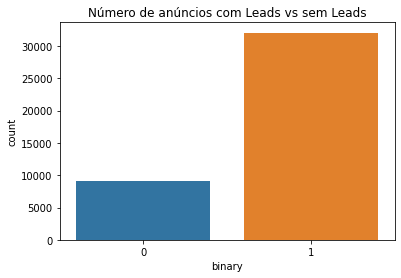

In [173]:
sns.countplot(x='binary', data=df4);
plt.title('Número de anúncios com Leads vs sem Leads');

print('Anúncios com lead(s):', df4[df4['binary'] == 1].shape[0])
print('Anúncios com lead(s):', df4[df4['binary'] == 0].shape[0])

**Leads**

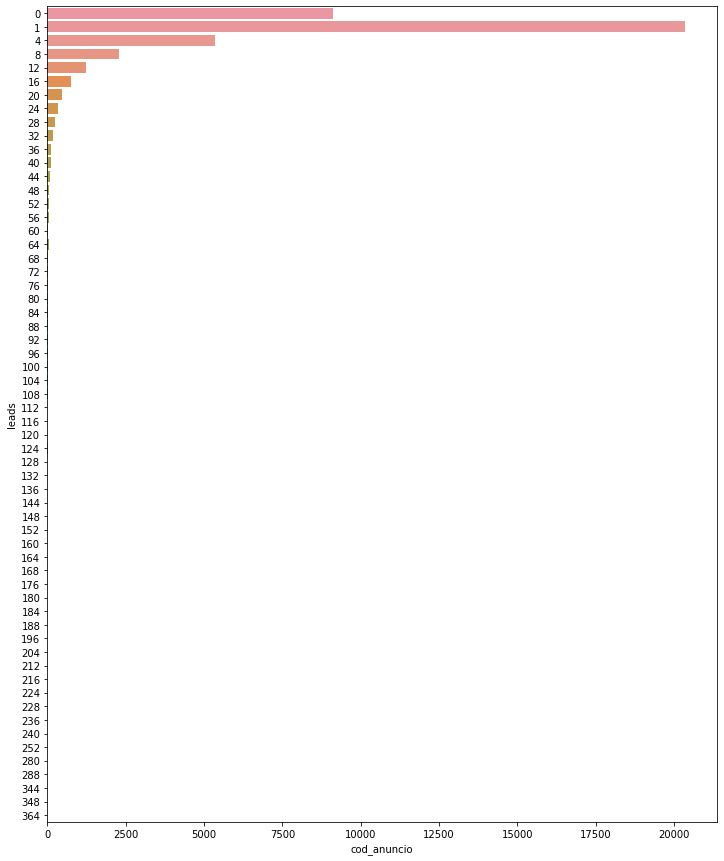

In [174]:
plt.gcf().set_size_inches(12,15)
aux = (df4[['leads', 'cod_anuncio']].groupby('leads')
                                    .count()
                                    .sort_values('cod_anuncio', ascending=False)
                                    .reset_index())

sns.barplot(x='cod_anuncio', y='leads', data=aux, orient='h');

### 5.1.2. prioridade (1=alta, 2-média, 3-baixa)

Não existe uma diferença significativa de leads com base na prioridade do anúncio.

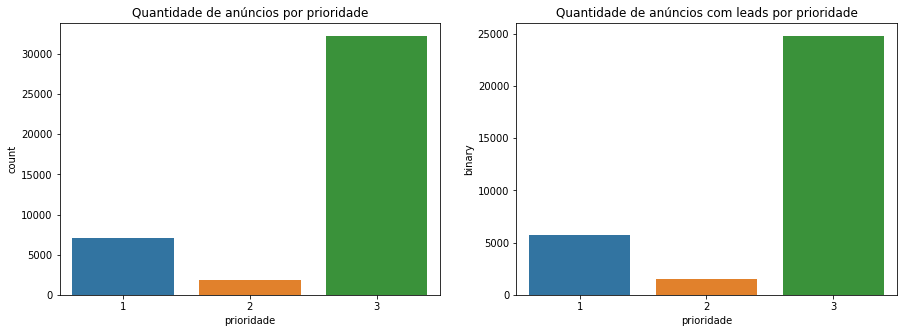

In [175]:
aux = (df4[['prioridade', 'binary']].groupby('prioridade')
                                    .sum()
                                    .sort_values('binary', ascending=False)
                                    .reset_index())

plt.gcf().set_size_inches(15,5)

plt.subplot(1,2,1)
sns.countplot(x='prioridade',data=df4).set_title('Quantidade de anúncios por prioridade');

plt.subplot(1,2,2)
sns.barplot(x='prioridade', y='binary', data=aux).set_title('Quantidade de anúncios com leads por prioridade');

In [176]:
aux1 = df4.query('prioridade == 3')
aux2 = df4.query('prioridade == 2')
aux3 = df4.query('prioridade == 1')
aux4 = aux1['binary'].value_counts()[1] / len(aux1)
aux5 = aux2['binary'].value_counts()[1] / len(aux2)
aux6 = aux3['binary'].value_counts()[1] / len(aux3)

print(f'{100 * aux4:.2f}% dos anúncios prioridade 3 receberam leads.')
print(f'{100 * aux5:.2f}% dos anúncios prioridade 2 receberam leads.')
print(f'{100 * aux6:.2f}% dos anúncios prioridade 1 receberam leads.')

76.85% dos anúncios prioridade 3 receberam leads.
83.40% dos anúncios prioridade 2 receberam leads.
81.12% dos anúncios prioridade 1 receberam leads.


### 5.1.3. qtd_fotos

Anúncios com 8 fotos correspondem à 55% dos leads gerados.

In [177]:
aux = df4.query('binary == 1')
aux1 = df4.query('binary == 0')

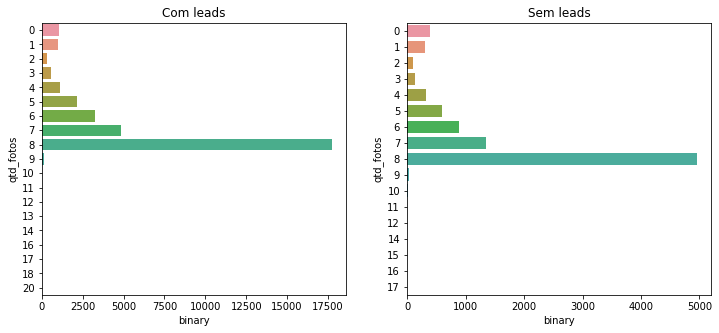

In [178]:
aux2 = aux[['qtd_fotos', 'binary']].groupby('qtd_fotos').count().sort_values('binary', ascending=False).reset_index()
aux3 = aux1[['qtd_fotos', 'binary']].groupby('qtd_fotos').count().sort_values('binary', ascending=False).reset_index()

plt.gcf().set_size_inches(12,5)

plt.subplot(1,2,1)
sns.barplot(x='binary', y='qtd_fotos', data=aux2, orient='h').set_title('Com leads')

plt.subplot(1,2,2)
sns.barplot(x='binary', y='qtd_fotos', data=aux3, orient='h').set_title('Sem leads');

In [179]:
aux2['binary'][0] / aux2['binary'].sum()

0.5528047145396152

### 5.1.4. vlr_mercado & vlr_anuncio

Nos dados disponibilizados no dataset, os valores dos anúncios serem maiores ou menores que os valores do mercado não impactam no recebimento de leads.

In [180]:
# valor do veículo menor ou igual ao valor do mercado
aux = df4
aux['vlr_merc_menor'] = (df4['vlr_anuncio'] / df4['vlr_mercado']).apply(lambda x: 1 if x <= 1 else 0)
aux[['vlr_merc_menor', 'binary']]

aux1 = aux.query('vlr_merc_menor == 0')
aux2 = aux.query('vlr_merc_menor == 1')
aux3 = aux1['binary'].value_counts()[1] / len(aux1)
aux4 = aux2['binary'].value_counts()[1] / len(aux2)

print('Quantidade de anúncios com valor MAIOR que o de mercado:', len(aux1))
print('Quantidade de anúncios com valor MENOR ou igual que o de mercado:', len(aux2))
print('---------------------------------------------------------------------------')
print(f'{100 * aux3:.2f}% dos anúncios com valor MAIOR que o de mercado receberam leads.')
print(f'{100 * aux4:.2f}% dos anúncios com valor MENOR ou igual que o de mercado receberam leads.')

Quantidade de anúncios com valor MAIOR que o de mercado: 19317
Quantidade de anúncios com valor MENOR ou igual que o de mercado: 21863
---------------------------------------------------------------------------
76.20% dos anúncios com valor MAIOR que o de mercado receberam leads.
79.36% dos anúncios com valor MENOR ou igual que o de mercado receberam leads.


### 5.1.5. flg_licenciado

O veículo ser licenciado é considerado importante para a demonstração de interesse no anúncio.

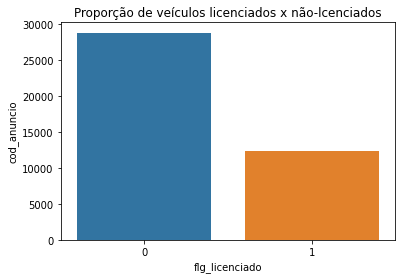

In [181]:
aux = (df4[['flg_licenciado', 'cod_anuncio']].groupby('flg_licenciado')
                                             .count()
                                             .sort_values('cod_anuncio', ascending=False)
                                             .reset_index())

sns.barplot(x='flg_licenciado', y='cod_anuncio', data=aux).set_title('Proporção de veículos licenciados x não-lcenciados');

In [182]:
aux1 = df4.query('flg_licenciado == 1')
aux2 = aux1['binary'].value_counts()[1] / len(aux1)

print(f'{100 * aux2:.2f}% de todos os veículos licenciados do dataset receberam leads.')

80.93% de todos os veículos licenciados do dataset receberam leads.


### 5.1.6. flg_ipva_pago

O veículo estar com o IPVA pago é considerado importante para a demonstração de interesse no anúncio.

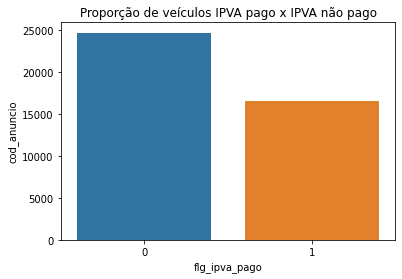

In [183]:
aux = (df4[['flg_ipva_pago', 'cod_anuncio']].groupby('flg_ipva_pago')
                                             .count()
                                             .sort_values('cod_anuncio', ascending=False)
                                             .reset_index())

sns.barplot(x='flg_ipva_pago', y='cod_anuncio', data=aux).set_title('Proporção de veículos IPVA pago x IPVA não pago');

In [184]:
aux1 = df4.query('flg_ipva_pago == 1')
aux2 = aux1['binary'].value_counts()[1] / len(aux1)

print(f'{100 * aux2:.2f}% de todos os veículos com IPVA pago do dataset receberam leads.')

79.90% de todos os veículos com IPVA pago do dataset receberam leads.


### 5.1.7. flg_aceita_troca

O anunciante aceitar troca é considerado importante para a demonstração de interesse no anúncio.

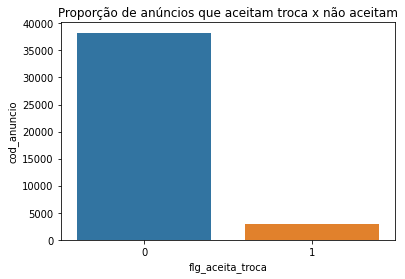

In [185]:
aux = (df4[['flg_aceita_troca', 'cod_anuncio']].groupby('flg_aceita_troca')
                                               .count()
                                               .sort_values('cod_anuncio', ascending=False)
                                               .reset_index())

sns.barplot(x='flg_aceita_troca', y='cod_anuncio', data=aux).set_title('Proporção de anúncios que aceitam troca x não aceitam');

In [186]:
aux1 = df4.query('flg_aceita_troca == 1')
aux2 = aux1['binary'].value_counts()[1] / len(aux1)

print(f'{100 * aux2:.2f}% de todos os anúncios que aceitam troca do dataset receberam leads.')

83.49% de todos os anúncios que aceitam troca do dataset receberam leads.


## 5.2. Hypotheses Testing 

### 5.2.1. [Falsa] 01. Veículos com IPVA pago correspondem a 70% dos anúncios com leads.

**R: Veículos com IPVA pago correspondem à 41.17% dos anúncios com leads. Porém, veiculos com IPVA pago tem uma média de leads 2.66 vezes maior que os veículos sem IPVA pago.**

Veículos com IPVA pago correspondem à 41.17% dos anúncios com leads


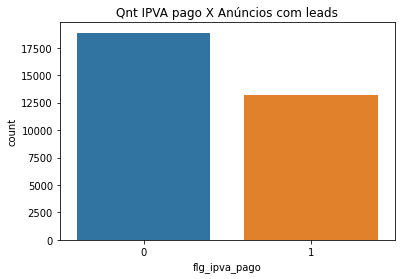

In [187]:
aux = df4.query('binary == 1')
sns.countplot(x=aux['flg_ipva_pago']).set_title('Qnt IPVA pago X Anúncios com leads');

print(f'Veículos com IPVA pago correspondem à {aux["flg_ipva_pago"].value_counts()[1] / len(aux) * 100:.2f}% dos anúncios com leads')

In [188]:
aux1 = aux.query('flg_ipva_pago == 1')['leads'].mean()
aux2 = aux.query('flg_ipva_pago == 0')['leads'].mean()

print('Média de leads recebidos em veículos com IPVA Pago:', int(aux1))
print('Média de leads recebidos em veículos com IPVA Pago:', int(aux2))

Média de leads recebidos em veículos com IPVA Pago: 7
Média de leads recebidos em veículos com IPVA Pago: 3


### 5.2.2. [Falsa] 02. Duas marcas de veículos correspondem a 60% dos anúncios com leads.

**R: Cinco marcas de veículos corresponddem a aproximadamente 60% dos anúncios com leads. As marcas são: 2, 5, 4, 3, 30**

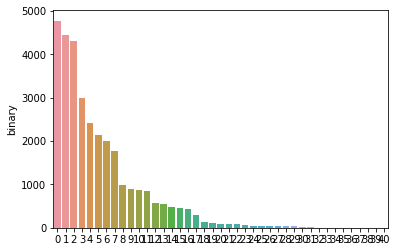

In [301]:
aux = df4.query('binary == 1')

aux1 = (aux[['cod_marca_veiculo', 'binary']].groupby('cod_marca_veiculo')
                                            .sum()
                                            .sort_values('binary', ascending=False)
                                            .reset_index())

sns.barplot(x=aux1.index, y=aux1['binary']);

In [302]:
aux2 = aux1['cod_marca_veiculo'].iloc[:5].values.tolist()
aux3 = len(aux[aux['cod_marca_veiculo'].isin(aux2)]) / len(aux)
print(f'As marcas {aux2} representam {100 * aux3:.2f}% dos anúncios que receberam leads.')

As marcas [2, 5, 4, 3, 30] representam 59.09% dos anúncios que receberam leads.


### 5.2.3. [Verdadeira] 03. Veículos com ano de fabricação inferior a 2010 geram até 20% dos leads.

**R: Veículos com ano de fabricação menor ou igual 2010 correspondem a apenas 16.70% dos veículos que recebem leads.**

Veículos com ano de fabricação menor ou igual 2010 correspondem a apenas 16.73% dos veículos que recebem leads.


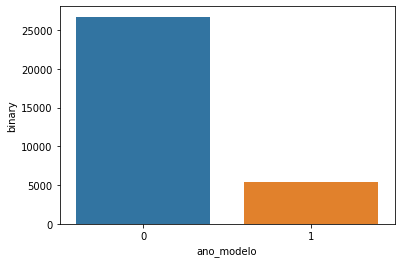

In [191]:
aux = df4.query('binary == 1')
aux1 = aux['ano_modelo'].apply(lambda x: 1 if x <= 2010 else 0)
aux2 = pd.concat([aux['binary'], aux1], axis=1)
aux3 = aux2.groupby('ano_modelo').sum().reset_index()

sns.barplot(x='ano_modelo', y='binary', data=aux3);

aux4 = aux3['binary'][1] / aux3['binary'].sum()
print(f'Veículos com ano de fabricação menor ou igual 2010 correspondem a apenas {100 * aux4:.2f}% dos veículos que recebem leads.')

**Para os próximos ciclos, verificar quais são as caracteristicas presentes nos veículos com ano inferior a 2010 que receberam leads e comparar com os que não receberam, com o objetivo de orientar os anúnciantes.**

### 5.2.4. [Verdadeira] 04. Veiculos Flex correspondem a no mínimo 60% dos leads.

**Veículos flex correspondem a 76.49% dos veículos que recebem leads.**

Veículos flex correspondem a 76.49% dos veículos que recebem leads.


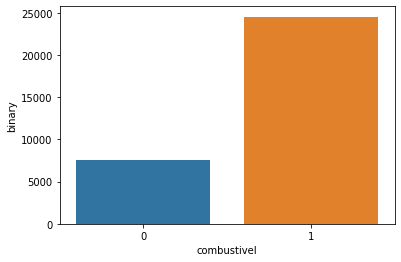

In [192]:
aux = df4.query('binary == 1')
aux2 = ['gasolina', 'diesel', 'gas natural', 'alcool']
aux3 = aux['combustivel'].apply(lambda x: 0 if x in aux2 else 1)
aux4  = pd.concat([aux['binary'], aux3], axis=1)
aux5 = aux4.groupby('combustivel').sum().reset_index()

sns.barplot(x='combustivel', y='binary', data=aux5);

aux6 = aux5['binary'][1] / aux4['binary'].sum()
print(f'Veículos flex correspondem a {100 * aux6:.2f}% dos veículos que recebem leads.')

**Para os próximos ciclos, verificar quais são as caracteristicas presentes nos veículos que não flex e que receberam leads e comparar com os que não receberam, com o objetivo de orientar os anúnciantes.**

### 5.2.5. [Verdadeira] 05. São Paulo concentra 80% dos anúncios que possuem mais de 30 leads.

**São Paulo concentra 87.07% dos anúncios que possuem mais de 30 leads.**

**Para os anúncios com mais de 20 leads, São Paulo concentra 82.73%.**

**Para os anúncios com mais de 10 leads, São Paulo concentra 76.61%.**

In [202]:
# função para calcular a porcentam de SP em diferentes quantidades minimas de leads 
def calc_perc_sp(data, num_leads):
    aux = data[data['leads'] >= num_leads]
    aux1 = aux[['uf', 'leads']].groupby('uf').count().reset_index().sort_values('leads', ascending=False)
    
    plot = sns.barplot(x='uf', y='leads', data=aux1);
    
    aux2 = aux1[aux1['uf'] == 'SP']['leads']
    aux3 = aux1['leads'].sum()
    aux4 = aux2 / aux3
    
    resultado = f'São Paulo concentra {(aux4.values * 100)[0]:.2f}% dos anúncios que possuem mais de {num_leads} leads.'
    
    return resultado

'São Paulo concentra 87.07% dos anúncios que possuem mais de 30 leads.'

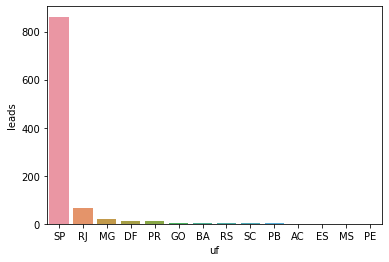

In [203]:
resultado_30 = calc_perc_sp(df4, 30)
resultado_30

'São Paulo concentra 82.73% dos anúncios que possuem mais de 20 leads.'

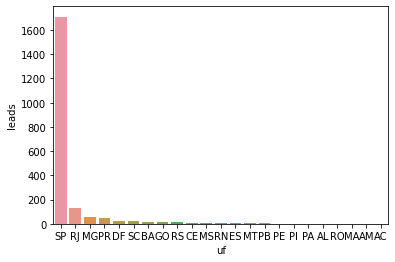

In [204]:
resultado_20 = calc_perc_sp(df4, 20)
resultado_20

'São Paulo concentra 76.61% dos anúncios que possuem mais de 10 leads.'

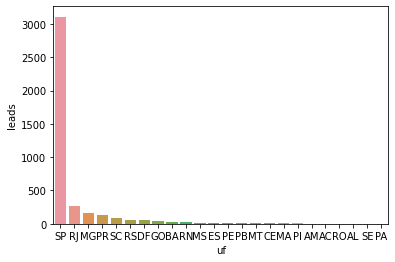

In [205]:
resultado_10 = calc_perc_sp(df4, 10)
resultado_10

**Para os próximos ciclos, verificar quais são as caracteristicas presentes nos anúncios de SP com mais de 30, 20 e 10 leads e comparar com os anúncios dos outros estados, para identificar se existe diferenças e o que pode ser melhorado para aumentar essa porcentagem para os outros estados.**

### 5.2.6. [Falso] 06. **Anúncios com menos de 5 fotos correspondem a no mínimo 70% dos que não recebem leads.**

**Anúncios com menos de 5 fotos correspondem à 13.92% dos anúncios que não receberam leads.**

In [197]:
aux = df4.query('binary == 0')
aux1 = aux.query('qtd_fotos < 5')
print(f'Anúncios com menos de 5 fotos correspondem à {100 * len(aux1) / len(aux):.2f}% dos anúncios que não receberam leads.')

Anúncios com menos de 5 fotos correspondem à 13.92% dos anúncios que não receberam leads.


### 5.2.7. [Falsa] 07. A mediana da quantidade de fotos no anúncio é 2x maior para anúncios que receberam leads.

**A mediana e a distribuição da quantidade de fotos para anúncios com e sem leads são as mesmas.**

Mediana de fotos para os que receberam leads:  8.0
Mediana de fotos para os que n receberam leads: 8.0


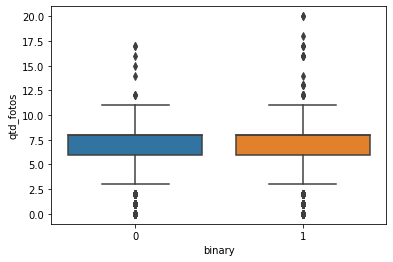

In [198]:
aux_leads = df4.query('binary == 1')['qtd_fotos'].median()
aux_nleads = df4.query('binary == 0')['qtd_fotos'].median()

print('Mediana de fotos para os que receberam leads: ', aux_leads)
print('Mediana de fotos para os que n receberam leads:', aux_nleads)

sns.boxplot(x='binary', y='qtd_fotos', data=df4);

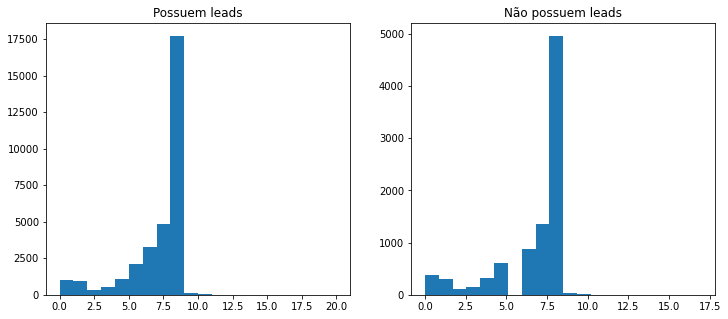

In [199]:
plt.gcf().set_size_inches(12,5)

plt.subplot(1,2,1)
plt.hist(df4.query('binary == 1')['qtd_fotos'], bins=20);
plt.title('Possuem leads')

plt.subplot(1,2,2)
plt.hist(df4.query('binary == 0')['qtd_fotos'], bins=20);
plt.title('Não possuem leads');

### 5.2.8. [Falsa] 08. Anúncios com valor do veículo inferior a 10% da tabela FIPE correspondem a 50% dos que recebem leads.

**Anúncios com o valor do veículo inferior a 10% do valor de mercado correspondem à 7.8% dos que recebem leads.**

In [200]:
aux = df4.query('binary == 1')
aux1 = (aux['vlr_anuncio'] / aux['vlr_mercado']).apply(lambda x: 1 if x < 0.90 else 0)
aux2 = aux1.value_counts()[1] / len(aux)

print(f'Anúncios com o valor do veículo inferior a 10% do valor de mercado correspondem à {100 * aux2:.1f}% dos que recebem leads.')

Anúncios com o valor do veículo inferior a 10% do valor de mercado correspondem à 7.8% dos que recebem leads.


### 5.2.9. [Verdadeiro] 09. Anúncios em que o anunciante é PJ correspondem a 60% dos que recebem leads.

**Anúncios em que o anunciante é PJ representa 86.81% dos que recebem leads.**

Anúncios em que o anunciante é PJ representa 86.81% dos que recebem leads.


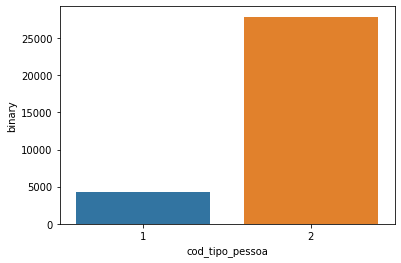

In [201]:
# tipo de anunciante: PF=1, PJ=2
aux = df4[['cod_tipo_pessoa', 'binary']].groupby('cod_tipo_pessoa').sum().reset_index()
aux1 = aux['binary'][1] / aux['binary'].sum()

sns.barplot(x='cod_tipo_pessoa', y='binary', data=aux);

print(f'Anúncios em que o anunciante é PJ representa {100 * aux1:.2f}% dos que recebem leads.')

**Para os próximos ciclos, verificar quais são as caracteristicas presentes nos anúncios que são de anunciantes PF e receberam leads e comparar com os que não receberam.**

# 6. DATA PRE-PROCESSING

In [213]:
df5 = df_train.copy()

## 6.1. Drop Unnecessary columns & Saving IDs

In [214]:
# salvar código do anuncio
cod_anuncio_cliente_column_train = df5[['cod_anuncio', 'cod_cliente']]

# remover colunas que não serão utilizadas
df5 = df5.drop(columns=['cod_anuncio', 'cod_cliente'])

## 6.2. Feature Scaling

> **views | cliques_telefone* | ano_modelo | cep_2dig | vlr_anuncio | qtd_fotos | km_veiculo | vlr_mercado | portas**

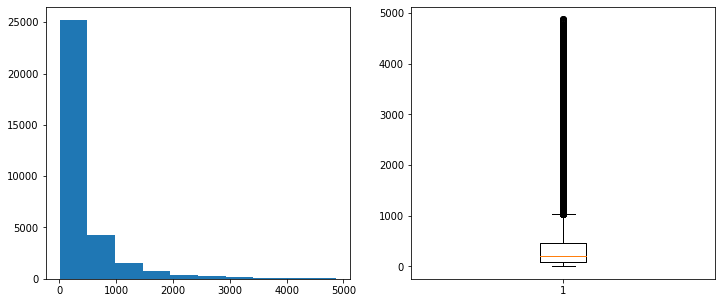

In [215]:
# # Aplicando Scalers
plt.gcf().set_size_inches(12,5)

plt.subplot(1,2,1)
plt.hist(df5['views']);

plt.subplot(1,2,2)
plt.boxplot(df5['views']);

In [216]:
# views
rs_views = RobustScaler()
df5['views'] = rs_views.fit_transform(df5[['views']])

# cliques_telefone
rs_cliques_telefone = RobustScaler() 
df5['cliques_telefone*'] = rs_cliques_telefone.fit_transform(df5[['cliques_telefone*']])

# ano_modelo
rs_ano_modelo = RobustScaler() 
df5['ano_modelo'] = rs_ano_modelo.fit_transform(df5[['ano_modelo']])

# vlr_anuncio
rs_vlr_anuncio = RobustScaler() 
df5['vlr_anuncio'] = rs_vlr_anuncio.fit_transform(df5[['vlr_anuncio']])

# km_veiculo
rs_km_veiculo = RobustScaler() 
df5['km_veiculo'] = rs_km_veiculo.fit_transform(df5[['km_veiculo']])

# vlr_mercado
rs_vlr_mercado = RobustScaler() 
df5['vlr_mercado'] = rs_vlr_mercado.fit_transform(df5[['vlr_mercado']])

# portas
rs_portas = RobustScaler() 
df5['portas'] = rs_portas.fit_transform(df5[['portas']])

# cep_2dig
mm_cep_2dig = MinMaxScaler()
df5['cep_2dig'] = mm_cep_2dig.fit_transform(df5[['cep_2dig']])

# qtd_fotos
mm_qtd_fotos = MinMaxScaler()
df5['qtd_fotos'] = mm_qtd_fotos.fit_transform(df5[['qtd_fotos']])

## 6.3. Encoding

In [217]:
# # Frequency Encoding
# cod_marca_veiculo
frq_cod_marca_veiculo = df5.groupby('cod_marca_veiculo').size() / len(df5)
df5['cod_marca_veiculo'] = df5['cod_marca_veiculo'].map(frq_cod_marca_veiculo)

# cod_modelo_veiculo
frq_cod_modelo_veiculo = df5.groupby('cod_modelo_veiculo').size() / len(df5)
df5['cod_modelo_veiculo'] = df5['cod_modelo_veiculo'].map(frq_cod_modelo_veiculo)

# cod_versao_veiculo
frq_cod_versao_veiculo = df5.groupby('cod_versao_veiculo').size() / len(df5)
df5['cod_versao_veiculo'] = df5['cod_versao_veiculo'].map(frq_cod_versao_veiculo)

# uf
frq_uf = df5.groupby('uf').size() / len(df5)
df5['uf'] = df5['uf'].map(frq_uf)

# cidade
frq_cidade = df5.groupby('cidade').size() / len(df5)
df5['cidade'] = df5['cidade'].map(frq_cidade)

# combustivel
frq_combustivel = df5.groupby('combustivel').size() / len(df5)
df5['combustivel'] = df5['combustivel'].map(frq_combustivel)

# cambio
frq_cambio = df5.groupby('cambio').size() / len(df5)
df5['cambio'] = df5['cambio'].map(frq_cambio)

# qnt_opcionais
frq_qnt_opcionais = df5.groupby('qnt_opcionais').size() / len(df5)
df5['qnt_opcionais'] = df5['qnt_opcionais'].map(frq_qnt_opcionais)

## 6.4. Dataset Balancing (SMOTE + Tomek Link)

In [218]:
# definir quantidade das classes
ratio_balanced =  {1: 25698, 0: 25600}
    
# definir amostragem
smtt = c.SMOTETomek(sampling_strategy=ratio_balanced, random_state=42, n_jobs=-1)

# aplicar amostragem
x_smtt, y_smtt = smtt.fit_resample(df5, df5['binary'])

# sobrescrever dados de treino
df5 = x_smtt

In [219]:
df5.dtypes

cod_tipo_pessoa                        int64
prioridade                             int64
leads                                  int64
views                                float64
cliques_telefone*                    float64
cod_marca_veiculo                    float64
cod_modelo_veiculo                   float64
cod_versao_veiculo                   float64
ano_modelo                           float64
cep_2dig                             float64
vlr_anuncio                          float64
qtd_fotos                            float64
km_veiculo                           float64
vlr_mercado                          float64
flg_unico_dono                         int64
flg_licenciado                         int64
flg_ipva_pago                          int64
flg_todas_revisoes_concessionaria      int64
flg_todas_revisoes_agenda_veiculo      int64
flg_garantia_fabrica                   int64
flg_blindado                           int64
flg_aceita_troca                       int64
flg_adapta

# 7. MODEL SELECTION

In [220]:
df6 = df5.copy()

In [221]:
# Criar X & y
X = df6.drop(columns=['leads', 'binary'])
y = df6[['leads', 'binary']]

# Treino & Teste
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

## 7.1. Feature Importance

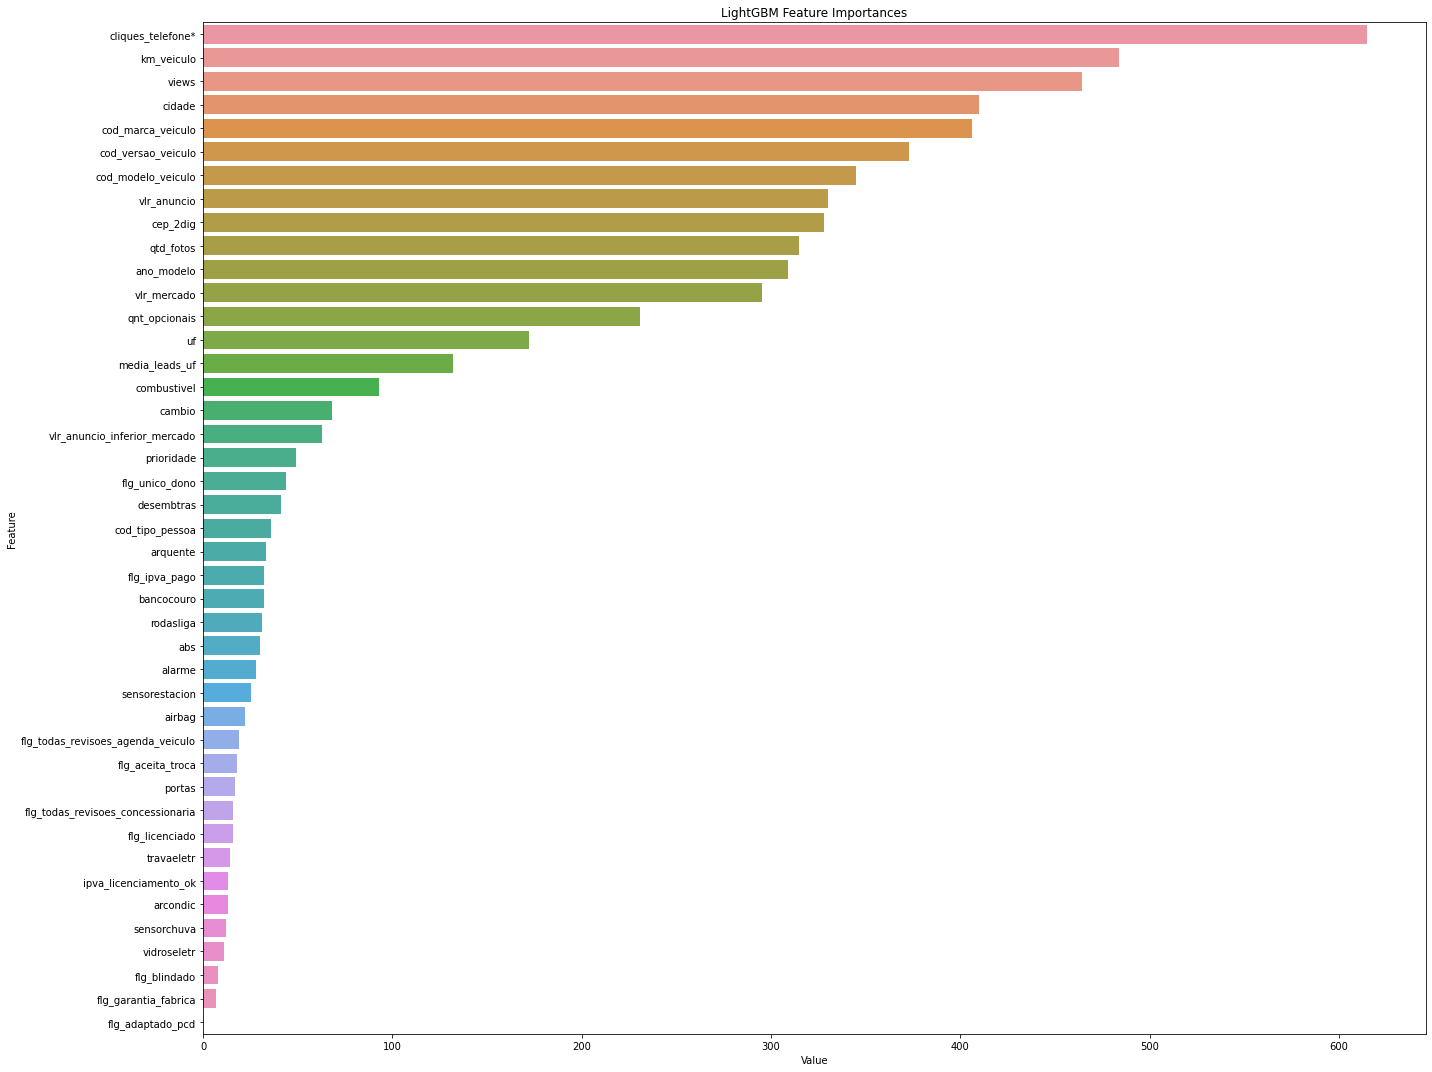

In [222]:
lgbm = lightgbm.LGBMClassifier(n_estimators=200)
lgbm.fit(x_train, y_train['binary'] )

feature_imp = pd.DataFrame(sorted(zip(lgbm.feature_importances_,X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 15))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Feature Importances')
plt.tight_layout()
plt.show()

In [223]:
# colunas selecionadas pelo feature importance
lgbm_cols_selected = feature_imp.sort_values('Value', ascending=False)['Feature'][0:16].tolist()

# colunas selecionadas com base na análise exploratória dos dados
eda_base_cols_selected = ['vlr_anuncio_inferior_mercado', 'prioridade', 'flg_ipva_pago', 'cod_tipo_pessoa', 'flg_unico_dono',
                          'flg_aceita_troca', 'flg_licenciado', 'ipva_licenciamento_ok']

# concat
cols_selected = lgbm_cols_selected + eda_base_cols_selected

# 8. MACHINE LERANING

In [224]:
x_train_ml = x_train[cols_selected]
x_val_ml = x_val[cols_selected]

## 8.1. Algorithms

A **Acuracia** será a principal métrica utilizada para avaliar os modelos, dado que as classes foram balanceadas na etapa de pré-processamento. As métricas a seguir também serao analisadas para complementar a análise dos resultados: **Precision, Recall, F1-Score e ROC_AUC Score**.

### 8.1.1. Naive Bayes

In [225]:
# instanciar modelo
nb_model = GaussianNB()

# treinar
nb_model.fit(x_train_ml, y_train['binary'])

# prediction
y_pred_nb = nb_model.predict(x_val_ml)

# calcula métricas
nb_metrics = compute_metrics(y_val['binary'], y_pred_nb, 'Naive Bayes')

### 8.1.2. Random Forest

In [226]:
# instanciar modelo
rf_model = RandomForestClassifier(n_jobs=-1,
                                  n_estimators=200)

# treinar
rf_model.fit(x_train_ml, y_train['binary'])

# prediction
y_pred_rf = rf_model.predict(x_val_ml)

# calcula métricas
rf_metrics = compute_metrics(y_val['binary'], y_pred_rf, 'Random Forest')

### 8.1.3. LightGBM 

In [227]:
# instanciar modelo
lgbm_model = lightgbm.LGBMClassifier(n_estimators=200)

# treinar
lgbm_model.fit(x_train_ml, y_train['binary'])

# predict
y_pred_lgbm = lgbm_model.predict(x_val_ml)
y_pred_proba_lgbm = lgbm_model.predict_proba(x_val_ml)

# calcula métricas
lgbm_metrics = compute_metrics(y_val['binary'], y_pred_lgbm, 'LightGBM')

## 8.2. Cross-Validation

In [230]:
# merge datasets de treino e validação
X = pd.concat([x_train_ml, x_val_ml], axis=0)
y = pd.concat([y_train['binary'], y_val['binary']], axis=0)

In [232]:
# instanciar cv
cv = RepeatedKFold(n_splits=15, n_repeats=5, random_state=42)

# cv para os três modelos
cv_nb   = cross_validation(nb_model, 'Naive Bayes', X, y, cv)
cv_rf   = cross_validation(rf_model, 'Random Forest', X, y, cv)
cv_lgbm = cross_validation(lgbm_model, 'LightGBM', X, y, cv)

## 8.3. CV Comparison

**Sem Cross-Validation:**

In [237]:
pd.concat([nb_metrics, rf_metrics, lgbm_metrics], axis=0)

,Model,Precision (Avg+Std),Recall (Avg+Std),F1-Score (Avg+Std),ROC-AUC (Avg+Std),Accuracy (Avg+Std)
0,Naive Bayes,0.714,0.176,0.283,0.552,0.550
0,Random Forest,0.797,0.966,0.873,0.858,0.859
0,LightGBM,0.780,0.996,0.875,0.855,0.856


**Com Cross-Validation:**

In [238]:
pd.concat([cv_nb, cv_rf, cv_lgbm], axis=0)

,Model,Precision (Avg+Std),Recall (Avg+Std),F1-Score (Avg+Std),ROC-AUC (Avg+Std),Accuracy (Avg+Std)
0,Naive Bayes,0.722 +/- %0.022,0.176 +/- %0.010,0.282 +/- %0.013,0.615 +/- %0.009,0.553 +/- %0.008
0,Random Forest,0.801 +/- %0.009,0.971 +/- %0.005,0.878 +/- %0.006,0.919 +/- %0.005,0.865 +/- %0.006
0,LightGBM,0.778 +/- %0.009,0.996 +/- %0.001,0.874 +/- %0.006,0.888 +/- %0.005,0.856 +/- %0.006


**Tamanho do Modelo Treinado:**

In [235]:
pd.DataFrame({'Modelo': ['Naive Bayes', 'Random Forest', 'LightGBM'], 
              'TamanhoMB': [get_size(nb_model), get_size(rf_model), get_size(lgbm_model)]})

,Modelo,TamanhoMB
0,Naive Bayes,0.00
1,Random Forest,171.03
2,LightGBM,0.66


**Diante dos resultados apresentados, o modelo criado utilizando o LightGBM será o utilizado, avançando para a etapa de tunagem dos hiperparametros.** 

## 8.4. Hyperparameter Fine Tuning

### 8.4.1 Bayesian Search

In [270]:
# espaço de pesquisa
params = {'boosting_type': ['gbdt', 'dart', 'goss'],
          'n_estimators': np.arange(50, 251),
          'learning_rate': np.arange(0.01, 0.11, 0.01),
          'num_leaves': np.arange(5, 31),
          'max_depth': np.arange(5, 201)} 

# Cross-validation
cv = RepeatedKFold(n_splits=15, 
                   n_repeats=10, 
                   random_state=42)

# instanciando o Bayesian Search
search = BayesSearchCV(estimator=lightgbm.LGBMClassifier(), 
                       search_spaces=params, 
                       n_jobs=-1, 
                       cv=cv)

# fit
search.fit(X, y);

In [272]:
# melhores parâmetros encontrados
search.best_params_

OrderedDict([('boosting_type', 'gbdt'),
             ('learning_rate', 0.08),
             ('max_depth', 149),
             ('n_estimators', 236),
             ('num_leaves', 22)])

### 8.4.2. Model Tuned

In [273]:
# instanciar modelo
lgbm_model_tuned = lightgbm.LGBMClassifier(boosting_type='gbdt',
                                           learning_rate=0.08,
                                           max_depth=149,
                                           n_estimators=236,
                                           num_leaves=22)

# treinar
lgbm_model_tuned.fit(x_train_ml, y_train['binary'])

# predict
y_pred_lgbm_tuned = lgbm_model_tuned.predict(x_val_ml)
y_pred_proba_lgbm_tuned = lgbm_model_tuned.predict_proba(x_val_ml)

# calcula métricas
lgbm_metrics = compute_metrics(y_val['binary'], y_pred_lgbm_tuned, 'LightGBM - Tuned')

### 8.4.3. Confusion Matrix Comparison

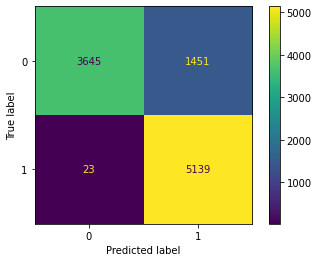

In [274]:
# gerando CM e plotando
cm_stand = plot_cm(y_val['binary'], y_pred_lgbm, lgbm_model)
cm_stand

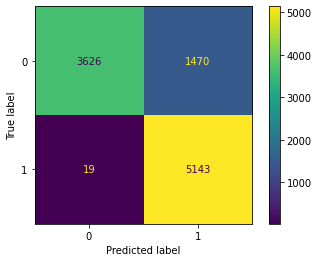

In [275]:
# gerando CM e plotando
cm_tuned = plot_cm(y_val['binary'], y_pred_lgbm_tuned, lgbm_model_tuned)
cm_tuned

### 8.4.4. ROC Curve Comparison

Código retirado da internet para plotar a Curva ROC

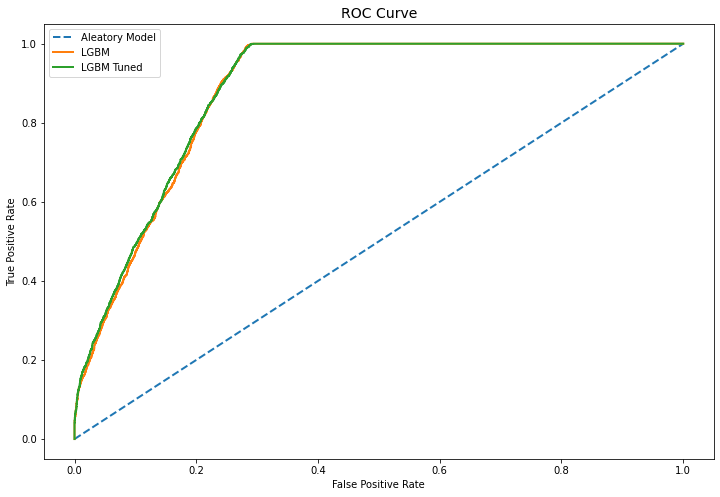

In [276]:
# use the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(12, 8)

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_val['binary']))]

# calculates the roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_val['binary'], ns_probs)
lgbm_fpr, lgbm_tpr, _ = roc_curve(y_val['binary'], y_pred_proba_lgbm[:,1])
tuned_lgbm_fpr, tuned_lgbm_tpr, _ = roc_curve(y_val['binary'], y_pred_proba_lgbm_tuned[:,1])

# plots the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--',linewidth=2, label='Aleatory Model')
plt.plot(lgbm_fpr, lgbm_tpr, marker=',',linewidth=2, label='LGBM')
plt.plot(tuned_lgbm_fpr, tuned_lgbm_tpr, marker=',',linewidth=2, label='LGBM Tuned')

# sets plot features
plt.title("ROC Curve", fontsize=14)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# displays the legend
plt.legend()

# displays the plot
plt.show();

### 8.5.5. Cross-Validation Comparison

In [277]:
# define K-fold
cv = RepeatedKFold(n_splits=2, n_repeats=1, random_state=1)

# aplica o cv nos modelos com e sem hptune
st_lgbm = cross_validation(lgbm_model, 'LightGBM', X, y, cv)
cv_lgbm = cross_validation(lgbm_model_tuned, 'LightGBM - Tuned', X, y, cv)

# concatenar para exibir a tabela
pd.concat([st_lgbm, cv_lgbm], axis=0)

,Model,Precision (Avg+Std),Recall (Avg+Std),F1-Score (Avg+Std),ROC-AUC (Avg+Std),Accuracy (Avg+Std)
0,LightGBM,0.779 +/- %0.001,0.990 +/- %0.001,0.872 +/- %0.001,0.886 +/- %0.001,0.854 +/- %0.001
0,LightGBM - Tuned,0.778 +/- %0.001,0.995 +/- %0.000,0.873 +/- %0.001,0.886 +/- %0.000,0.855 +/- %0.001


# 9. EVALUATE

## 9.1. Test Dataset Evaluation

Aplicação de todo o pipeline de limpezas e transformações desenvolvidas no projeto para os dados de teste.

In [278]:
x_test = df_test.copy()

In [279]:
x_test.dropna(inplace=True)

In [280]:
df_test = x_test.copy().reset_index()

In [281]:
x_test['binary'] = np.where(x_test['leads'] > 0, 1, 0)
y_test = x_test['binary']

In [282]:
x_test = x_test.drop(columns=['leads', 'binary'])

In [283]:
x_test['flg_ipva_pago'] = x_test['flg_ipva_pago'].astype('int64')                 
x_test['flg_todas_revisoes_concessionaria'] = x_test['flg_todas_revisoes_concessionaria'].astype('int64')
x_test['flg_garantia_fabrica'] = x_test['flg_garantia_fabrica'].astype('int64')
x_test['flg_adaptado_pcd'] = x_test['flg_adaptado_pcd'].astype('int64')

In [284]:
x_test['alarme'] = bin_change(x_test['alarme'])        
x_test['airbag'] = bin_change(x_test['airbag'])        
x_test['arquente'] = bin_change(x_test['arquente'])      
x_test['bancocouro'] = bin_change(x_test['bancocouro'])    
x_test['arcondic'] = bin_change(x_test['arcondic'])      
x_test['abs'] = bin_change(x_test['abs'])           
x_test['desembtras'] = bin_change(x_test['desembtras'])    
x_test['travaeletr'] = bin_change(x_test['travaeletr'])    
x_test['vidroseletr'] = bin_change(x_test['vidroseletr'])   
x_test['rodasliga'] = bin_change(x_test['rodasliga'])     
x_test['sensorchuva'] = bin_change(x_test['sensorchuva'])   
x_test['sensorestacion'] = bin_change(x_test['sensorestacion'])

In [285]:
x_test['uf'] = x_test['uf_cidade'].apply(lambda x: x.split('_')[0])
x_test['cidade'] = x_test['uf_cidade'].apply(lambda x: x.split('_')[1])

In [286]:
x_test['media_leads_uf'] = x_test['uf'].map(media_leads_uf_dict)

In [287]:
x_test['qnt_opcionais'] = x_test[['flg_blindado', 'alarme', 'airbag', 'arquente', 'bancocouro', 'arcondic', 'abs',
                            'desembtras', 'travaeletr', 'vidroseletr', 'rodasliga', 'sensorchuva', 
                            'sensorestacion']].sum(axis = 1).astype(str)

In [288]:
aux = x_test[['flg_licenciado', 'flg_ipva_pago']].sum(axis=1)
x_test['ipva_licenciamento_ok'] = aux.apply(lambda x: 1 if x == 2 else 0)

In [289]:
x_test['vlr_anuncio_inferior_mercado'] = (x_test['vlr_anuncio'] / x_test['vlr_mercado']).apply(lambda x: 1 if x <= 1 else 0)

In [290]:
x_test = x_test.drop(columns='uf_cidade')

In [291]:
cod_anuncio_e_cod_cliente_column = x_test[['cod_anuncio', 'cod_cliente']]

In [292]:
x_test = x_test.drop(columns=['cod_anuncio', 'cod_cliente'])

In [293]:
rs_views = RobustScaler()
rs_cliques_telefone = RobustScaler() 
rs_ano_modelo = RobustScaler() 
rs_vlr_anuncio = RobustScaler() 
rs_km_veiculo = RobustScaler() 
rs_vlr_mercado = RobustScaler() 
rs_portas = RobustScaler() 
mm_cep_2dig = MinMaxScaler()
mm_qtd_fotos = MinMaxScaler()

x_test['views'] = rs_views.fit_transform(x_test[['views']])
x_test['cliques_telefone*'] = rs_cliques_telefone.fit_transform(x_test[['cliques_telefone*']])
x_test['ano_modelo'] = rs_ano_modelo.fit_transform(x_test[['ano_modelo']])
x_test['vlr_anuncio'] = rs_vlr_anuncio.fit_transform(x_test[['vlr_anuncio']])
x_test['km_veiculo'] = rs_km_veiculo.fit_transform(x_test[['km_veiculo']])
x_test['vlr_mercado'] = rs_vlr_mercado.fit_transform(x_test[['vlr_mercado']])
x_test['portas'] = rs_portas.fit_transform(x_test[['portas']])
x_test['cep_2dig'] = mm_cep_2dig.fit_transform(x_test[['cep_2dig']])
x_test['qtd_fotos'] = mm_qtd_fotos.fit_transform(x_test[['qtd_fotos']])

In [294]:
frq_cod_marca_veiculo = x_test.groupby('cod_marca_veiculo').size() / len(x_test)
frq_cod_modelo_veiculo = x_test.groupby('cod_modelo_veiculo').size() / len(x_test)
frq_cod_versao_veiculo = x_test.groupby('cod_versao_veiculo').size() / len(x_test)
frq_uf = x_test.groupby('uf').size() / len(x_test)
frq_cidade = x_test.groupby('cidade').size() / len(x_test)
frq_combustivel = x_test.groupby('combustivel').size() / len(x_test)
frq_cambio = x_test.groupby('cambio').size() / len(x_test)
frq_qnt_opcionais = x_test.groupby('qnt_opcionais').size() / len(x_test)

x_test['cod_marca_veiculo'] = x_test['cod_marca_veiculo'].map(frq_cod_marca_veiculo)
x_test['cod_modelo_veiculo'] = x_test['cod_modelo_veiculo'].map(frq_cod_modelo_veiculo)
x_test['cod_versao_veiculo'] = x_test['cod_versao_veiculo'].map(frq_cod_versao_veiculo)
x_test['uf'] = x_test['uf'].map(frq_uf)
x_test['cidade'] = x_test['cidade'].map(frq_cidade)
x_test['combustivel'] = x_test['combustivel'].map(frq_combustivel)
x_test['cambio'] = x_test['cambio'].map(frq_cambio)
x_test['qnt_opcionais'] = x_test['qnt_opcionais'].map(frq_qnt_opcionais)

In [295]:
x_test = x_test[cols_selected]

In [296]:
y_pred_test = lgbm_model_tuned.predict(x_test)

In [297]:
pred_column = pd.DataFrame(y_pred_test)[0].rename('predições')

df_test_com_pred = pd.concat([df_test, pred_column], axis=1)

In [298]:
compute_metrics(y_test, y_pred_test, 'LightGBM - Final')

,Model,Precision (Avg+Std),Recall (Avg+Std),F1-Score (Avg+Std),ROC-AUC (Avg+Std),Accuracy (Avg+Std)
0,LightGBM - Final,0.923,0.116,0.206,0.541,0.307


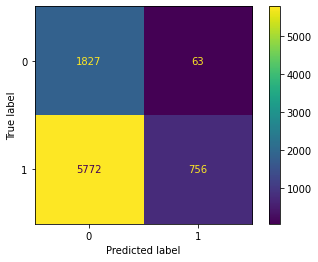

In [299]:
plot_cm(y_test, y_pred_test, lgbm_model_tuned)

In [300]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.24      0.97      0.39      1890
           1       0.92      0.12      0.21      6528

    accuracy                           0.31      8418
   macro avg       0.58      0.54      0.30      8418
weighted avg       0.77      0.31      0.25      8418



**Os resultados sobre os dados de teste foram inferiores se comparado aos dados de treino.**